In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from set_font import set_chinese_font
custom_font_path = 'Times_SimSun.ttf'
set_chinese_font(custom_font_path)

## 数据处理

In [2]:
poi = pd.read_csv('data/上海市2020年POI.zip', encoding='utf8')
road = gpd.read_file('data/路网.shp')
city = gpd.read_file('data/研究区.shp', encoding='utf-8')

### Road

<Axes: >

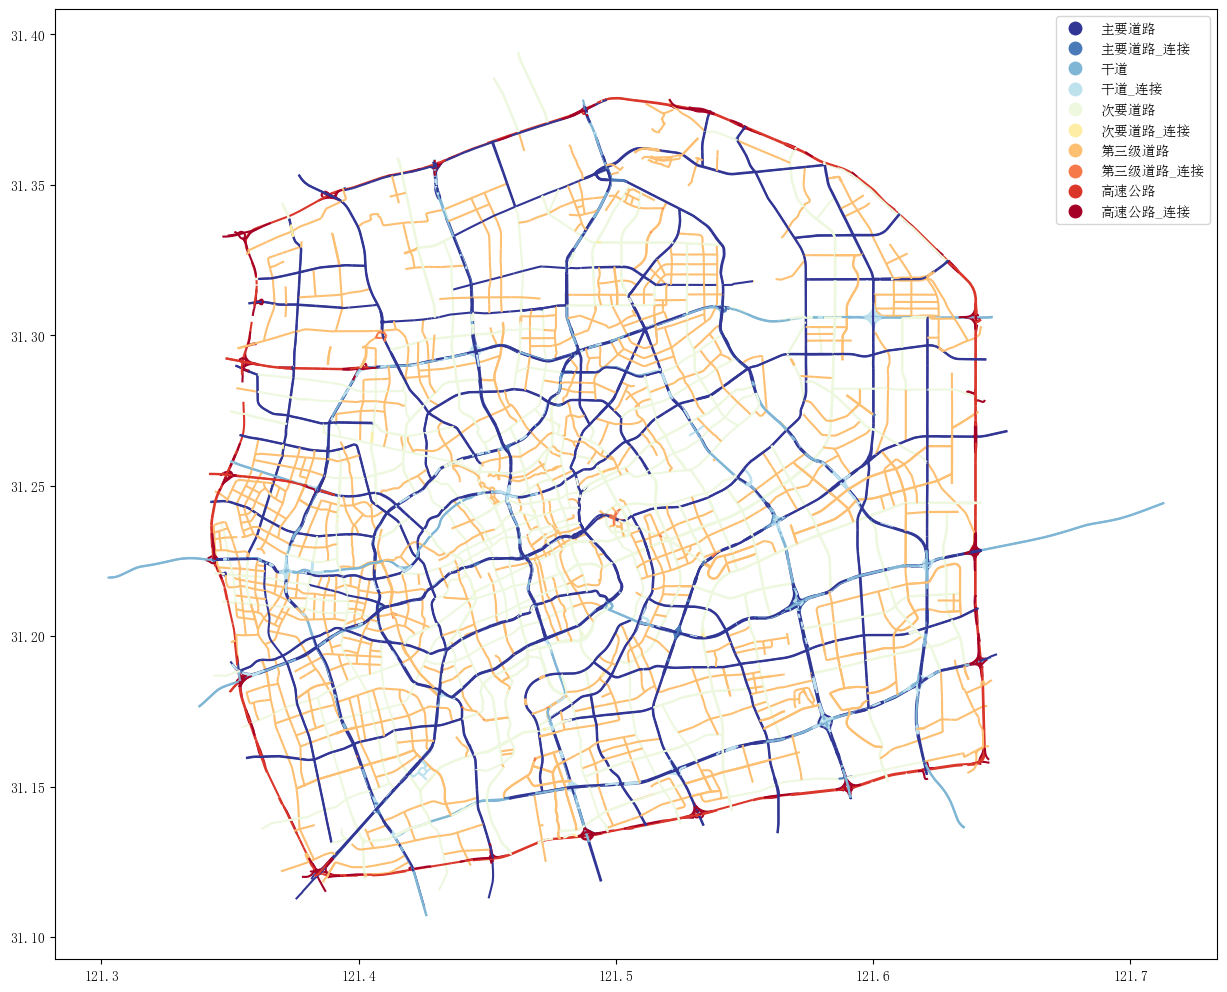

In [3]:
# 根据我们的研究选择相应等级的道路
# select_ = ['高速公路','干道','主要道路','次要道路','第三级道路']
select = ['高速公路','高速公路_连接','干道','干道_连接','主要道路','主要道路_连接','次要道路','次要道路_连接','第三级道路','第三级道路_连接']
road = road[road.fclass_cn.isin(select)].copy().reset_index(drop=True)
road.plot(column='fclass_cn', legend=True, figsize=(15,15), cmap='RdYlBu_r')

### POI

In [4]:
poi.drop(columns=['中类','小类'], inplace=True)
poi.rename(columns={'中类1':'中类','小类1':'小类'}, inplace=True)

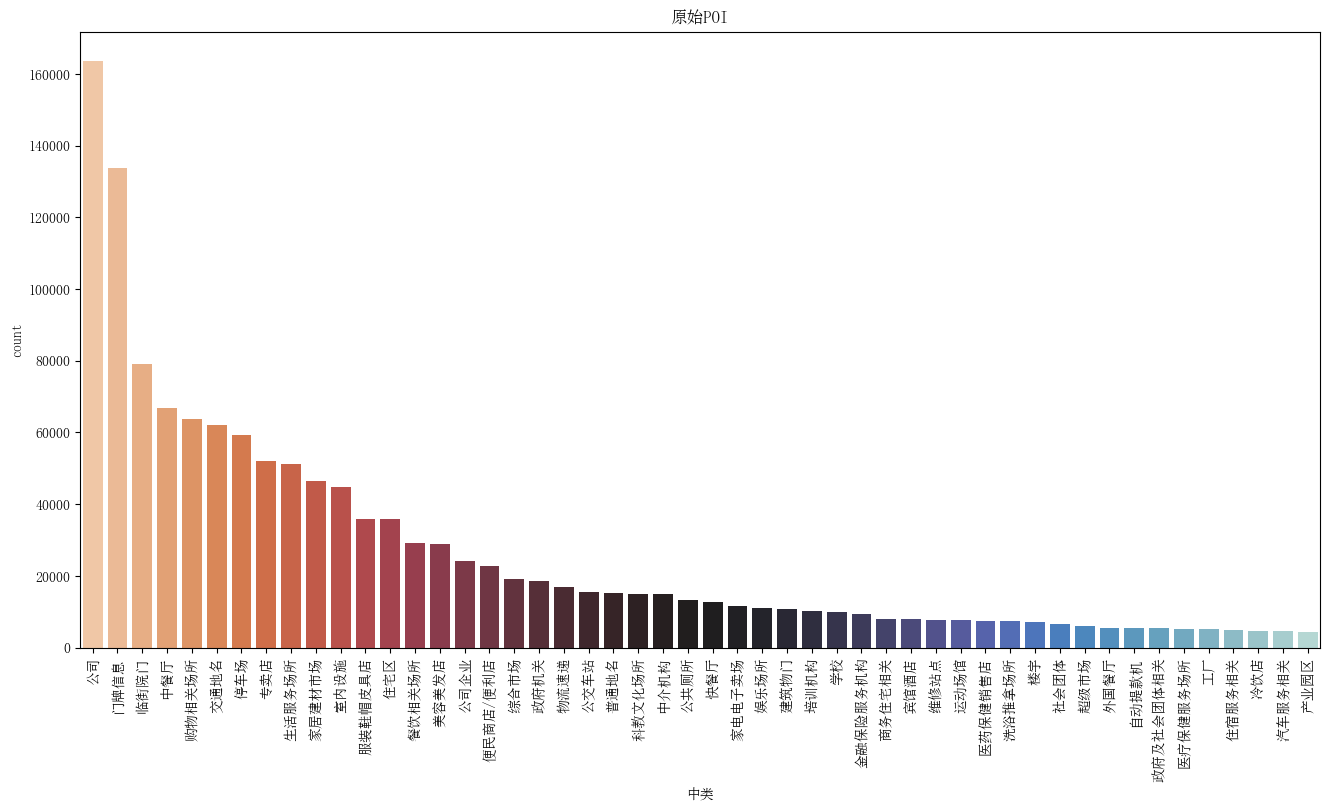

In [5]:
plt.figure(figsize=(16,8))
poi0 = poi.groupby(by='中类',as_index=False).agg({'小类':'count'}).rename(columns={'小类':'count'})
sns.barplot(x='中类', y='count', data=poi0.sort_values(by='count',ascending=False).head(50), hue='中类', palette='icefire_r')
plt.xticks(rotation=90)
plt.title('原始POI')
plt.show()

In [6]:
# 先过滤POI数据
DROP_1 = ['道路附属设施','地名地址信息','事件活动','室内设施','虚拟数据','通行设施','交通设施服务']  # 一类
DROP_2 = ['自动提款机','报刊亭']  # 二类
SAVE_2 = ['机场相关','火车站','长途汽车站']  # 二类

poi = poi[~poi['大类'].isin(DROP_1)]
poi = poi[~poi['中类'].isin(DROP_2) | poi['中类'].isin(SAVE_2)]

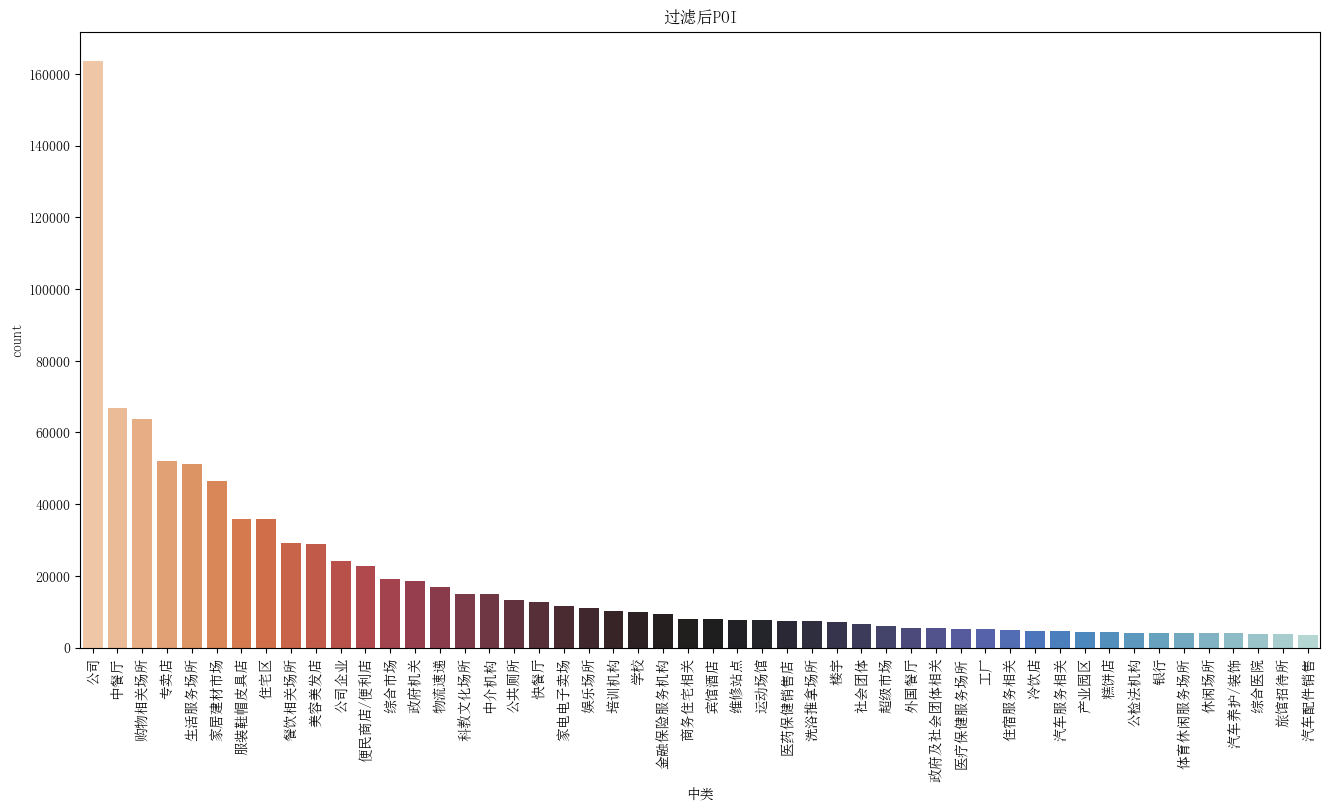

In [7]:
plt.figure(figsize=(16,8))
poi0 = poi.groupby(by='中类',as_index=False).agg({'小类':'count'}).rename(columns={'小类':'count'})
sns.barplot(x='中类', y='count', data=poi0.sort_values(by='count',ascending=False).head(50), hue='中类', palette='icefire_r')
plt.xticks(rotation=90)
plt.title('过滤后POI')
plt.show()

In [8]:
poi.reset_index(drop=True, inplace=True)
poi['poiID'] = poi.index

In [9]:
# poi转换为GeoDataFrame
poi = gpd.GeoDataFrame(poi, geometry=gpd.points_from_xy(poi['wgs84lon'], poi['wgs84lat']), crs='EPSG:4326')

In [10]:
# 提取研究区内的POI
poi = poi.clip(city)

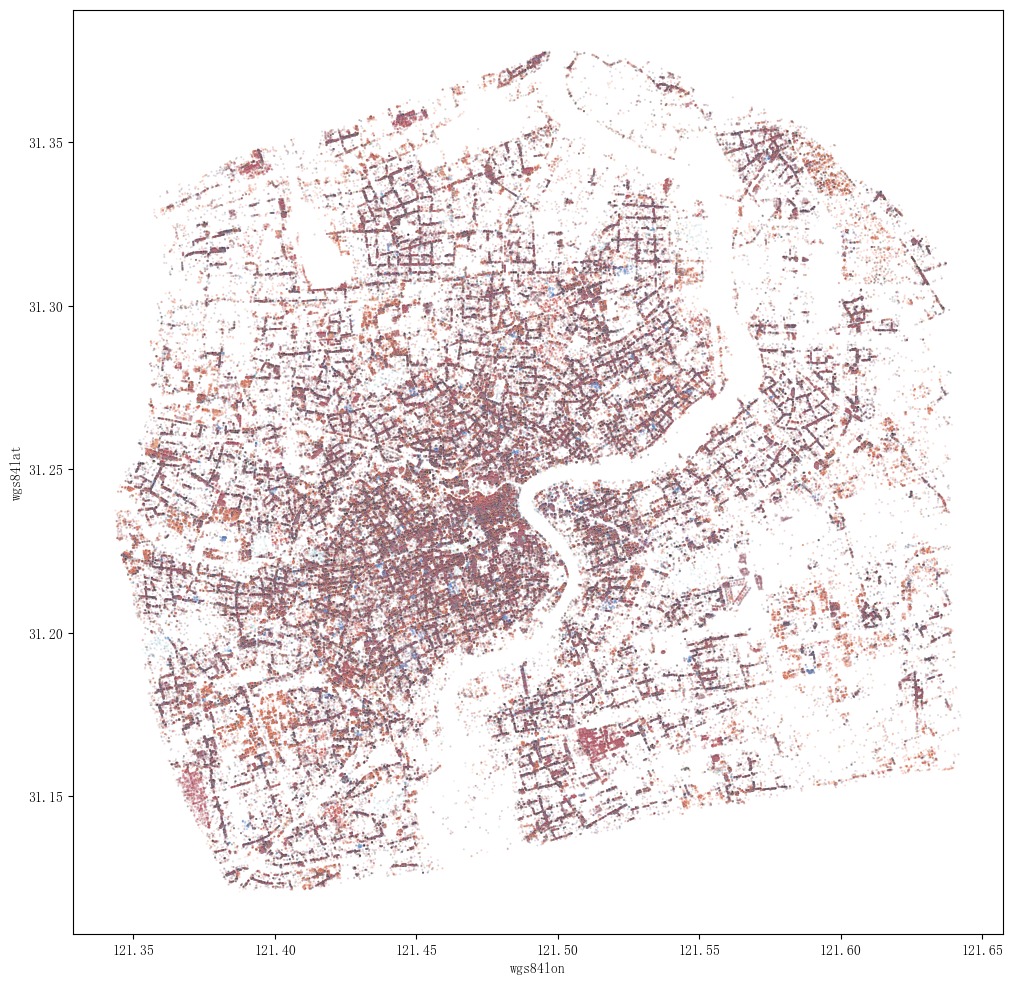

In [11]:
plt.figure(figsize=(12,12))
sns.scatterplot(x='wgs84lon', y='wgs84lat', data=poi, hue='大类', palette='icefire_r', s=2, alpha=0.2, legend=False)
plt.show()

## TAZ

In [12]:
def get_different_buffer(gdf, field, buffer_distances):
    gdf_out = gpd.GeoDataFrame()
    groups = gdf.groupby(field)
    for level, group in groups:
        if level in buffer_distances:
            # 创建指定宽度的缓冲区
            buffered = group.buffer(buffer_distances[level])
            gdf_buffer = gpd.GeoDataFrame(group[field], geometry=buffered)
            gdf_out = pd.concat([gdf_out, gdf_buffer], ignore_index=True)
    return gdf_out

In [13]:
buffer_distances = {
    '高速公路': 40, '高速公路_连接': 40,
    '干道': 40, '干道_连接': 40,
    '主要道路': 40, '主要道路_连接': 40,
    '次要道路': 20, '次要道路_连接': 20,
    '第三级道路': 10, '第三级道路_连接': 10
}
road_buffer = get_different_buffer(road.to_crs(32651), 'fclass_cn', buffer_distances)  # 转换为投影坐标系

<Axes: >

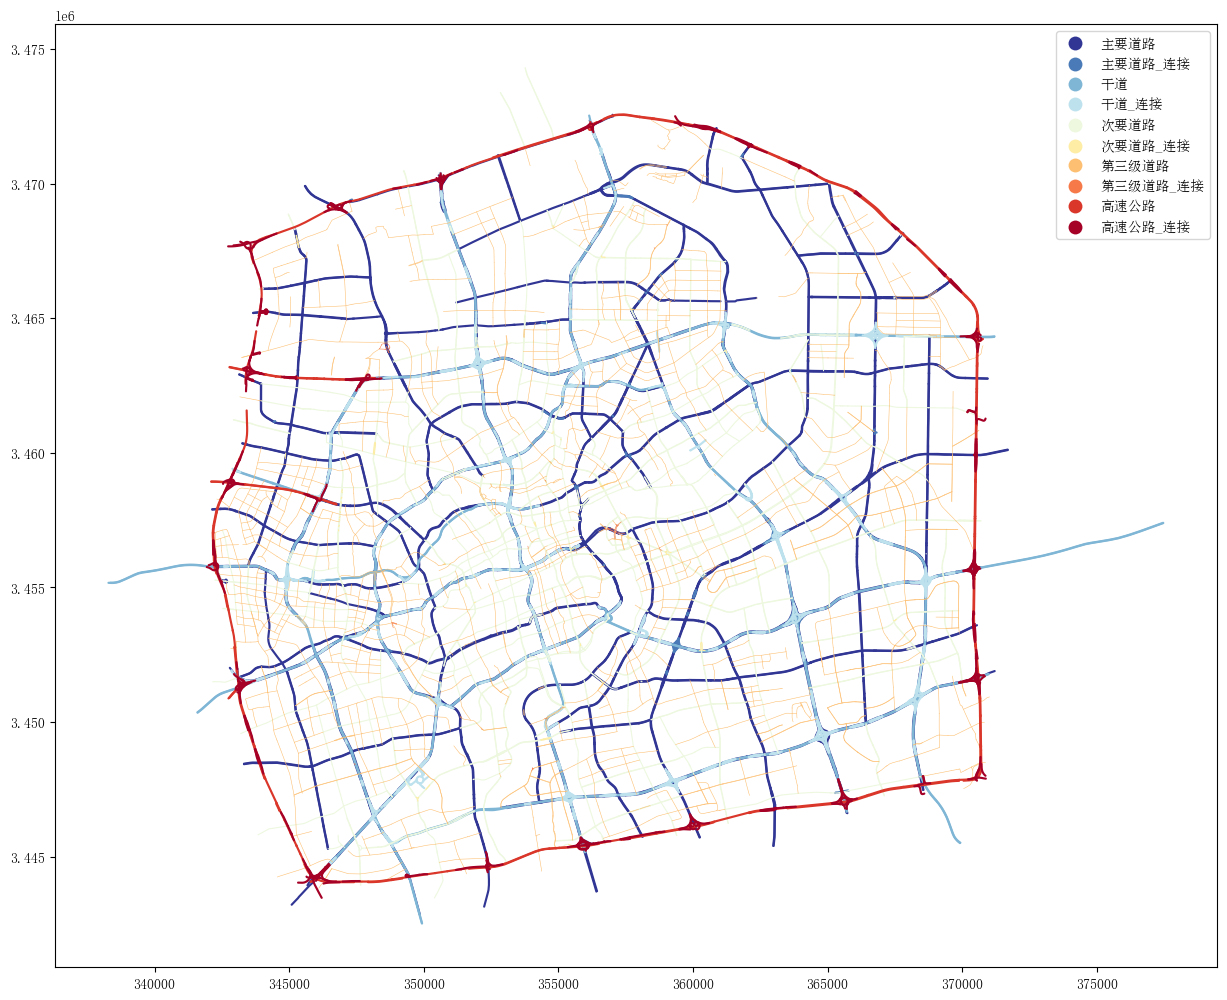

In [14]:
road_buffer.plot(column='fclass_cn', legend=True, figsize=(15,15), cmap='RdYlBu_r')

In [15]:
import momepy as mm

enclosures = mm.enclosures(road_buffer, limit=city.to_crs(32651))  # 围合区域

<Axes: >

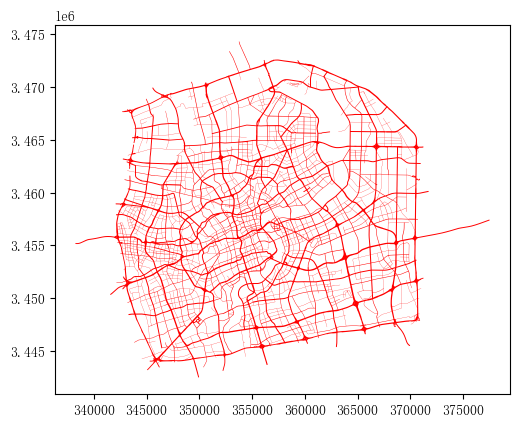

In [16]:
enclosures.head(1).plot(color='red') # 该方法获取到围合区域包含了缓冲区路网，后续需要剔除

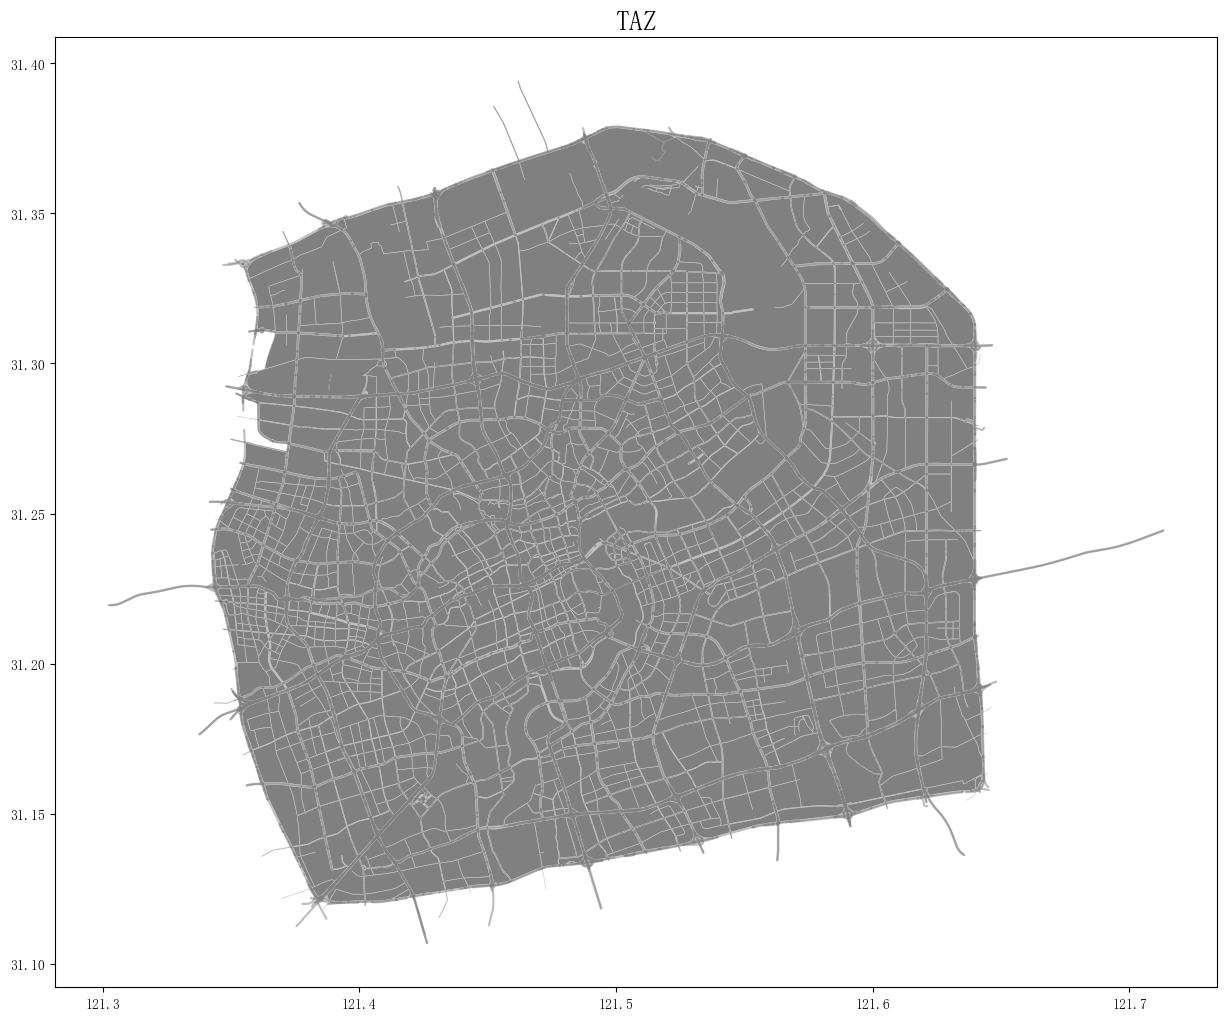

In [23]:
# 过滤路网
taz = enclosures[enclosures['eID']!=0].copy()
taz.reset_index(drop=True, inplace=True)
taz = taz.to_crs(4326)

ax = taz.plot(figsize=(15,15), color='grey')
road_buffer.to_crs(4326).plot(ax=ax ,color='grey', alpha=0.5)
plt.title('TAZ', fontsize=20)
plt.show()

## 地理语料库

In [24]:
# 空间连接
poi_taz = gpd.sjoin(poi, taz, predicate='within').dropna(subset=['eID'])
poi_taz

name                  address pname cityname adname  \
127348  上海罗阳制冷成套设备有限公司                梅陇镇景福路18号   上海市      上海市    闵行区   
127339      上海森诺贸易有限公司                梅陇镇景福路18号   上海市      上海市    闵行区   
552487         协和罗阳幼儿园         梅陇镇罗锦路888号8支弄22号   上海市      上海市    闵行区   
552440         联报万象梅陇站            莘朱路1258-1号楼附近   上海市      上海市    闵行区   
653067            回收香烟                  景福路西50米   上海市      上海市    闵行区   
...                ...                      ...   ...      ...    ...   
346860          工商注册大厅                 淞滨路28号1楼   上海市      上海市    宝山区   
389711          小张汽修汽配  崇景路与G1501上海绕城高速交叉口南100米   上海市      上海市   浦东新区   
138739           创元七堆场                    江东路1号   上海市      上海市   浦东新区   
465641      上海宏兴物流有限公司                 江东路1号3号门   上海市      上海市   浦东新区   
465733           吴淞售票处                淞浦路100号附近   上海市      上海市    宝山区   

          wgs84lon   wgs84lat         大类         中类         小类   poiID  \
127348  121.406138  31.121398       公司企业         公司         公司  127348   
127339  121.406138  31.121398       公司企业         公司       商业贸易  127339   
552487  121.392750  31.121456     科教文化服务     科教文化场所     科教文化场所  552487   
552440  121.410619  31.121467     科教文化服务     科教文化场所     科教文化场所  552440   
653067  121.405548  31.121486       购物服务        专卖店        专营店  653067   
...            ...        ...        ...        ...        ...     ...   
346860  121.495455  31.377491  政府机构及社会团体  政府及社会团体相关  政府及社会团体相关  346860   
389711  121.506782  31.377585       汽车维修       汽车维修       汽车维修  389711   
138739  121.505729  31.377666       公司企业         公司         公司  138739   
465641  121.505942  31.377696       生活服务       物流速递       物流速递  465641   
465733  121.497005  31.377721       生活服务        售票处        售票处  465733   

                          geometry  index_right   eID  
127348  POINT (121.40614 31.12140)          253   254  
127339  POINT (121.40614 31.12140)          253   254  
552487  POINT (121.39275 31.12146)          257   258  
552440  POINT (121.41062 31.12147)          253   254  
653067  POINT (121.40555 31.12149)          253   254  
...                            ...          ...   ...  
346860  POINT (121.49546 31.37749)         1639  1640  
389711  POINT (121.50678 31.37758)         1639  1640  
138739  POINT (121.50573 31.37767)         1639  1640  
465641  POINT (121.50594 31.37770)         1639  1640  
465733  POINT (121.49700 31.37772)         1639  1640  

[425570 rows x 14 columns]

In [25]:
# 邻近分析
poi_taz1 = poi[~poi['poiID'].isin(poi_taz['poiID'])].copy()
poi_taz1 = poi_taz1.sjoin_nearest(taz)
poi_taz = pd.concat([poi_taz,poi_taz1]).reset_index(drop=True)

d:\Anaconda3\envs\py311\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [26]:
poi_taz

name           address pname cityname adname  \
0             上海罗阳制冷成套设备有限公司         梅陇镇景福路18号   上海市      上海市    闵行区   
1                 上海森诺贸易有限公司         梅陇镇景福路18号   上海市      上海市    闵行区   
2                    协和罗阳幼儿园  梅陇镇罗锦路888号8支弄22号   上海市      上海市    闵行区   
3                    联报万象梅陇站     莘朱路1258-1号楼附近   上海市      上海市    闵行区   
4                       回收香烟           景福路西50米   上海市      上海市    闵行区   
...                      ...               ...   ...      ...    ...   
530236            秀桥旅馆(牡丹江路)         淞滨路103-1号   上海市      上海市    宝山区   
530237  中华联合财产保险公司上海市(宝山支公司)         牡丹江路50号附近   上海市      上海市    宝山区   
530238             宝山区珠义平杂货店         牡丹江路52号附近   上海市      上海市    宝山区   
530239               百岁山连锁超市           牡丹江路52号   上海市      上海市    宝山区   
530240         宝山区市容管理局(淞滨路)               泰和路   上海市      上海市    宝山区   

          wgs84lon   wgs84lat         大类      中类          小类   poiID  \
0       121.406138  31.121398       公司企业      公司          公司  127348   
1       121.406138  31.121398       公司企业      公司        商业贸易  127339   
2       121.392750  31.121456     科教文化服务  科教文化场所      科教文化场所  552487   
3       121.410619  31.121467     科教文化服务  科教文化场所      科教文化场所  552440   
4       121.405548  31.121486       购物服务     专卖店         专营店  653067   
...            ...        ...        ...     ...         ...     ...   
530236  121.494812  31.377365       住宿服务   旅馆招待所       旅馆招待所    6414   
530237  121.494711  31.377454     金融保险服务    保险公司        保险公司  862368   
530238  121.494803  31.377545       购物服务     专卖店         专营店  722385   
530239  121.494718  31.377585       购物服务  购物相关场所      购物相关场所  722375   
530240  121.495694  31.377688  政府机构及社会团体    政府机关  区县级政府及事业单位  345408   

                          geometry  index_right   eID  
0       POINT (121.40614 31.12140)          253   254  
1       POINT (121.40614 31.12140)          253   254  
2       POINT (121.39275 31.12146)          257   258  
3       POINT (121.41062 31.12147)          253   254  
4       POINT (121.40555 31.12149)          253   254  
...                            ...          ...   ...  
530236  POINT (121.49481 31.37737)         1639  1640  
530237  POINT (121.49471 31.37745)         1639  1640  
530238  POINT (121.49480 31.37755)         1639  1640  
530239  POINT (121.49472 31.37758)         1639  1640  
530240  POINT (121.49569 31.37769)         1639  1640  

[530241 rows x 14 columns]

In [28]:
import numpy as np
from tqdm import tqdm

def get_distance_matrix(points):
    """
    使用矩阵计算点之间的欧氏距离
    输入格式为 df[x,y]
    """
    n = points.shape[0]  # 获取数据长度
    tiled_points = np.tile(points, (n, 1, 1))  # 将数组points沿其第一个轴以n倍的方式进行复制拼接，而在其余轴上则保持原样: n*n*2
    # 原数组tiled_points的第二个轴（行）变为新数组的第一个轴（列）；
    # 原数组tiled_points的第一个轴（列）变为新数组的第二个轴（行）；
    # 原数组tiled_points的第三个轴保持不变，仍然是新数组的第三个轴。
    # n*n*2
    tiled_points_T = np.transpose(tiled_points, axes=(1, 0, 2))
    distance_matrix = np.linalg.norm(tiled_points - tiled_points_T, axis=2)
    return distance_matrix

# 左到右以此插入序列，可以得到的序列组合
def get_insert_sequences(node, nodes_list):
    insert_sequences = []
    for i in range(len(nodes_list) + 1):
        sequence = nodes_list.copy()  # 复制新的节点列表，避免在原列表上进行修改
        sequence.insert(i, node)  # 在指定位置插入节点
        insert_sequences.append(sequence)
    return insert_sequences

# 贪婪算法获取最短路径
def get_shortest_sequence(df):
    matrix = get_distance_matrix(df)
    distance_df = pd.DataFrame(data=matrix, index=df.index, columns=df.index)
    # 找到距离最大的两个点
    max_points = np.unravel_index(np.argmax(matrix), matrix.shape)

    # 初始化最短路径长度为最大值
    start_node, end_node = max_points
    shortest_length_nodes = [start_node, end_node]
    nodes = [node for node in distance_df.index if node != start_node and node != end_node]
    shortest_sequence = shortest_length_nodes.copy()
    
    while len(nodes) > 0:
        # 选择插入节点
        node = np.random.choice(nodes)
        nodes.remove(node)
        # 生成插入序列
        insert_sequences = get_insert_sequences(node, shortest_sequence)
        # 初始化参数
        shortest_length = np.inf
        # 寻找最短路径
        for sequence in insert_sequences:
            sequence_length = 0
            for j in range(len(sequence) - 1):
                # 使用距离矩阵中的距离值
                sequence_length += matrix[sequence[j]][sequence[j+1]]
            
            if sequence_length < shortest_length:
                shortest_length = sequence_length
                shortest_sequence = sequence
                
    return shortest_sequence

In [32]:
run = False
if run:
    eIDs = []
    poi_documents = []
    
    for eID in tqdm(poi_taz.eID.unique(), desc='get shortest length'):
        group = poi_taz.query(f'eID=={eID}').copy().reset_index(drop=True)
        # 放大坐标，避免小数位数太多造成精度问题，导致结果不一致
        group['wgs84lon'] = group['wgs84lon'] * 1000
        group['wgs84lat'] = group['wgs84lon'] * 1000
    
        eIDs.append(eID)
        poi_documents.append(list(group.loc[get_shortest_sequence(group[['wgs84lon','wgs84lat']])]['中类']))

    Docs = pd.DataFrame(data={'eID':eIDs,'Doc':poi_documents})
    Docs.to_csv('data/地理语料库_taz.csv', index=False)
else:
    print('Flase run')
    Docs = pd.read_csv('data/地理语料库_taz.csv')

Flase run


In [33]:
import ast

Docs['Doc'] = Docs['Doc'].apply(lambda x: ast.literal_eval(x))
Docs

eID                                                Doc
0      254.0  [公司, 公司企业, 公司, 住宅区, 住宅区, 休闲场所, 科教文化场所, 政府及社会团体...
1      258.0  [体育休闲服务场所, 科教文化场所, 运动场馆, 综合市场, 专卖店, 宾馆酒店, 服装鞋帽...
2      239.0  [公共厕所, 旅行社, 旅行社, 公司, 生活服务场所, 便民商店/便利店, 糕饼店, 公司...
3      255.0  [汽车维修, 服装鞋帽皮具店, 购物相关场所, 家居建材市场, 住宅区, 科教文化场所, 专...
4      253.0  [公检法机构, 公检法机构, 公检法机构, 工商税务机构, 公检法机构, 商务住宅相关, 住...
...      ...                                                ...
1553   977.0                                       [公园广场, 公园广场]
1554  1515.0                                     [公共厕所, 购物相关场所]
1555  1439.0  [产业园区, 公司, 公司, 公司企业, 汽车维修, 汽车养护/装饰, 公司企业, 金融保险...
1556  1628.0                                       [公共厕所, 公共厕所]
1557  1644.0                                         [公司, 公司企业]

[1558 rows x 2 columns]

## Word2Vec

In [35]:
from gensim.models import Word2Vec 

In [36]:
# sentences=[["a","b"],["b","c"] ... ]
poi_corpus = [Doc for Doc in Docs.Doc]  # 每一行为一个文档

In [37]:
# 定义Word2Vec模型参数，使用Skip-Gram模型
model_params = {
    'vector_size': 200,  # 词向量维度
    'window': 5,  # 窗口大小
    'min_count': 1,  # 忽略出现次数少于1次的单词
    'workers': 4,  # 使用多线程
    'sg': 0,  # 1:Skip-Gram模型
}
model = Word2Vec(poi_corpus, **model_params)

In [38]:
model.build_vocab(poi_corpus)  # 构建词汇表
model.train(poi_corpus, total_examples=model.corpus_count, epochs=100)  # 训练模型

(16526861, 53026200)

In [39]:
# 获取所有单词列表
all_words = model.wv.index_to_key
print("前10个单词:", all_words[:10])
print("总单词数:", len(all_words))

前10个单词: ['公司', '购物相关场所', '中餐厅', '专卖店', '生活服务场所', '服装鞋帽皮具店', '家居建材市场', '住宅区', '餐饮相关场所', '美容美发店']
总单词数: 187


In [40]:
# 获取指定单词向量表示
model.wv['公司']

array([ 1.0616248e+00, -1.3078198e-01,  6.0508728e-01,  2.8422987e-02,
       -5.0674987e-01,  1.0790797e+00, -1.4021548e+00,  8.1702691e-01,
        1.5844860e+00,  9.1896510e-01, -7.1754390e-01,  7.1152788e-01,
        1.9274478e-01, -1.0155955e-01, -9.1875160e-01, -6.6535509e-01,
        1.8325515e-02, -3.1693587e-01, -1.0371282e+00, -4.8920134e-01,
       -2.2441986e-01,  1.4755049e-01,  3.1478128e-01, -1.7319672e-01,
        3.0604449e-01, -9.6195853e-01, -7.0828557e-01,  6.7742288e-01,
        6.4446270e-01,  1.3347825e+00, -1.0446919e+00,  9.3030226e-01,
       -1.0485626e-01,  3.6880964e-01, -8.2851124e-01,  6.2821776e-02,
       -7.7038240e-01,  1.4657868e-01, -6.2524122e-01, -2.5821457e+00,
       -2.1156912e+00,  2.0181410e+00,  5.6077999e-01,  1.6714139e-02,
       -1.7981073e+00,  1.7928925e-01,  4.2618451e-01, -6.2035155e-01,
       -1.2369794e+00,  1.2317791e+00,  1.3610116e+00, -1.8576616e+00,
        4.0252540e-01,  8.1464037e-02,  1.4806193e+00,  2.2372499e-01,
      

In [41]:
# 查找与给定单词最相似的单词
model.wv.most_similar('公司', topn=10)

[('公司企业', 0.7548952102661133),
 ('传媒机构', 0.7331078052520752),
 ('楼宇', 0.7189664840698242),
 ('事务所', 0.6930481791496277),
 ('金融保险服务机构', 0.684633731842041),
 ('保险公司', 0.6743248105049133),
 ('产业园区', 0.6567535400390625),
 ('知名企业', 0.6522383689880371),
 ('物流速递', 0.5702421069145203),
 ('外国机构', 0.4638840854167938)]

In [42]:
# 计算两个文档之间的相似度
i, j = 0, 4
x = Docs.loc[i,'Doc']
y = Docs.loc[j,'Doc']
print('文档：\n',x)
print('---------------------------------------')
print('文档：\n',y)
print('指定两个文档之间的相似度',model.wv.n_similarity(x,y))

文档：
 ['公司', '公司企业', '公司', '住宅区', '住宅区', '休闲场所', '科教文化场所', '政府及社会团体相关', '政府机关', '商务住宅相关', '政府机关', '购物相关场所', '银行', '邮局', '维修站点', '综合市场', '旅馆招待所', '住宅区', '生活服务场所', '综合市场', '彩票彩券销售点', '超级市场', '中餐厅', '美容美发店', '中餐厅', '餐饮相关场所', '专卖店', '中餐厅', '中餐厅', '中餐厅', '餐饮相关场所', '洗衣店', '中餐厅', '便民商店/便利店', '公检法机构', '综合市场', '综合市场', '专卖店', '购物相关场所', '公司', '中餐厅', '餐饮相关场所', '餐饮相关场所', '购物相关场所', '中餐厅', '综合市场', '购物相关场所', '政府机关', '冷饮店', '购物相关场所', '购物相关场所', '购物相关场所', '娱乐场所', '公共厕所', '楼宇', '政府机关', '公司', '公司', '美容美发店', '休闲场所', '政府机关', '快餐厅', '住宅区', '生活服务场所', '学校', '运动场馆', '购物相关场所', '公司', '充电站', '购物相关场所', '中餐厅', '购物相关场所', '公司企业', '公司企业', '公司', '生活服务场所', '公司', '公司企业', '公司', '公司企业', '公司', '公司', '公司', '公司', '公司企业', '公司', '公司', '专卖店', '餐饮相关场所', '公司', '传媒机构', '公司', '购物相关场所', '公司', '公司', '公司', '产业园区', '科教文化场所', '科教文化场所', '公司', '生活服务场所', '工厂', '公司', '服装鞋帽皮具店', '工厂', '公司', '服装鞋帽皮具店', '医疗保健服务场所', '洗浴推拿场所', '公司', '公司', '公司', '充电站', '住宅区', '家居建材市场', '公司', '汽车养护/装饰', '公司', '公司企业', '公司', '汽车服务相关', '生活服务场所', '公司', '汽车维修', '公司企业', '汽车

## TAZs向量

In [43]:
from sklearn.preprocessing import normalize

# 定义函数计算平均文档向量
def calculate_doc_mean_vector(model, doc):
    # 获取文档中每个单词的向量
    word_vectors = [model.wv[word] for word in doc if word in model.wv]
    if not word_vectors:
        # 如果文档中的所有单词都不在模型中，返回 None 或其他默认值
        return None
    # 计算单词向量的平均值作为文档向量
    doc_vector = np.mean(word_vectors, axis=0)
    return doc_vector

In [44]:
# 计算每个文档的平均向量
doc_vectors = [calculate_doc_mean_vector(model, doc) for doc in Docs.Doc]
doc_vectors = normalize(doc_vectors, norm='l2')

taz_embeddings = pd.DataFrame(doc_vectors, columns=[f'vector_{i+1}' for i in range(model.vector_size)])
taz_embeddings['eID'] = Docs['eID']

## 聚类分析

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

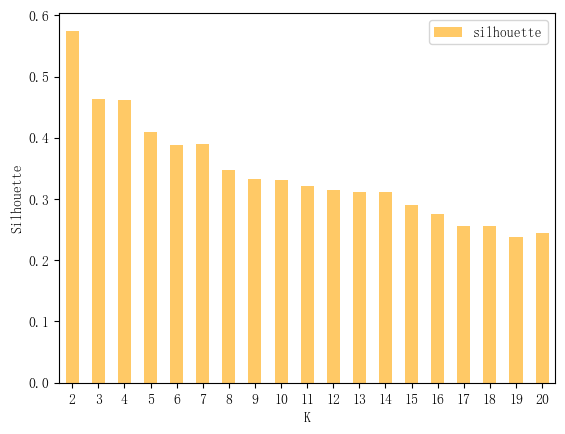

In [46]:
# 计算余弦相似度
cosine_sim = cosine_similarity(taz_embeddings.drop(columns='eID').values)
# cosine_sim = taz_embeddings.drop(columns='eID').values

# 设置参数
# 聚类分析
max_clusters = 20
ks = []
silhouettes = []
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(cosine_sim)
    silhouette = silhouette_score(cosine_sim, cluster_labels)
    ks.append(i)
    silhouettes.append(silhouette)

df_silhouette = pd.DataFrame(data={'silhouette':silhouettes,'k':ks})
df_silhouette.plot(x='k', y='silhouette', kind='bar', color='orange', alpha=0.6)
plt.xticks(rotation=0)
plt.ylabel('Silhouette')
plt.xlabel('K')
plt.show()

## 连接到空间位置

In [47]:
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(cosine_sim)
    Docs[f'k_{k}'] = cluster_labels
    Docs[f'k_{k}'] = Docs[f'k_{k}'].apply(lambda x: 'cluster '+str(x+1))
    print(Docs[f'k_{k}'].value_counts())

k_2
cluster 2    812
cluster 1    746
Name: count, dtype: int64
k_3
cluster 1    612
cluster 2    587
cluster 3    359
Name: count, dtype: int64
k_4
cluster 1    587
cluster 2    552
cluster 3    224
cluster 4    195
Name: count, dtype: int64
k_5
cluster 1    552
cluster 2    501
cluster 3    212
cluster 5    175
cluster 4    118
Name: count, dtype: int64
k_6
cluster 1    502
cluster 6    392
cluster 3    199
cluster 2    191
cluster 5    167
cluster 4    107
Name: count, dtype: int64
k_7
cluster 1    476
cluster 6    392
cluster 3    167
cluster 5    147
cluster 7    135
cluster 2    123
cluster 4    118
Name: count, dtype: int64
k_8
cluster 1    474
cluster 7    332
cluster 6    169
cluster 4    139
cluster 5    135
cluster 8    119
cluster 3     99
cluster 2     91
Name: count, dtype: int64
k_9
cluster 1    445
cluster 7    265
cluster 2    161
cluster 9    147
cluster 5    131
cluster 8    128
cluster 3    112
cluster 4     97
cluster 6     72
Name: count, dtype: int64


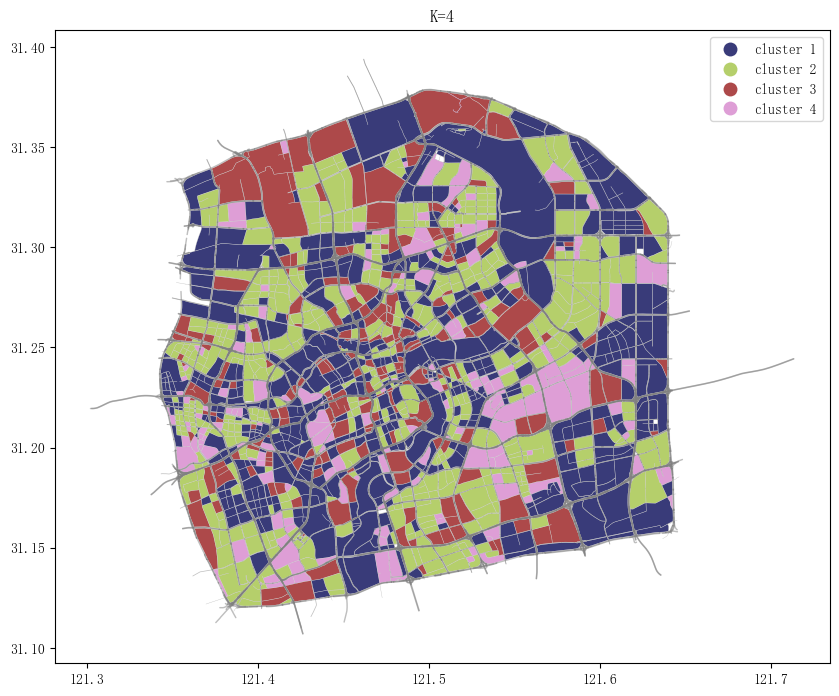

In [48]:
k = 4
ax = taz.merge(Docs[['eID',f'k_{k}']],on='eID',how='left').plot(column=f'k_{k}', figsize=(10,10), cmap='tab20b', legend=True)
road_buffer.to_crs(4326).plot(ax=ax ,color='grey', alpha=0.5)
plt.title(f'K={k}')
plt.show()

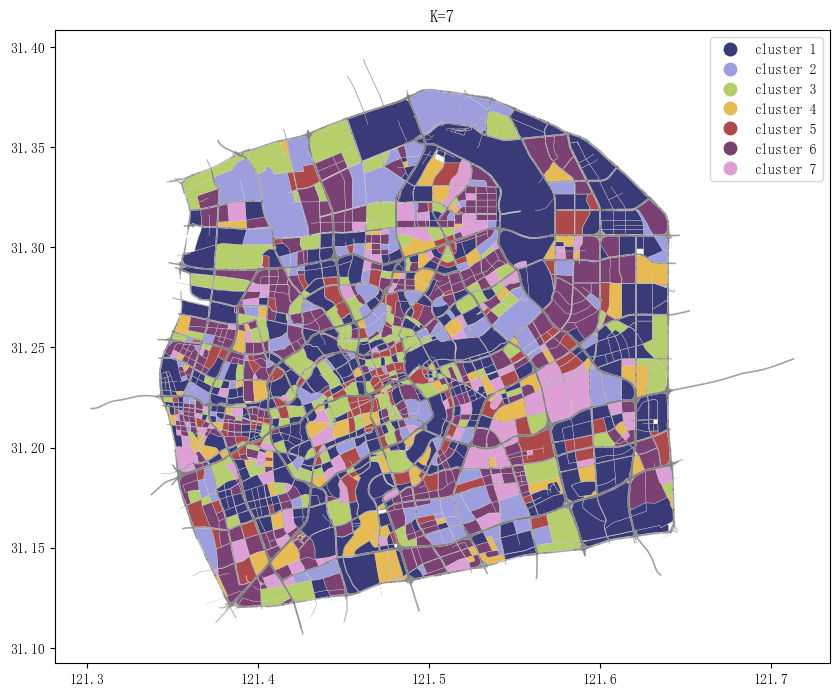

In [50]:
k = 7
ax = taz.merge(Docs[['eID',f'k_{k}']],on='eID',how='left').plot(column=f'k_{k}', figsize=(10,10), cmap='tab20b', legend=True)
road_buffer.to_crs(4326).plot(ax=ax ,color='grey', alpha=0.5)
plt.title(f'K={k}')
plt.show()

## 类内分析

### k=4

In [51]:
k = 4
df_k = poi_taz.merge(Docs[['eID',f'k_{k}']], on='eID', how='left').groupby([f'k_{k}','大类']).size().reset_index(name='count')  # 分组求和：k-类别
df_k = df_k.merge(df_k.groupby(f'k_{k}')['count'].sum().reset_index(), on=f'k_{k}', suffixes=('', '_sum'))  # k：组内和
df_k['percentage'] = (df_k['count'] / df_k['count_sum']) * 100 # 各组内得类别百分比
df_pivot = pd.pivot_table(df_k, index=f'k_{k}', columns='大类', values='percentage')  # 透视图

styled_df_pivot = df_pivot.style.background_gradient(cmap='coolwarm', axis=1).format("{:.2f}%")
styled_df_pivot

In [52]:
# 取反
df_k = poi_taz.merge(Docs[['eID',f'k_{k}']], on='eID', how='left').groupby(['大类',f'k_{k}']).size().reset_index(name='count')
df_k = df_k.merge(df_k.groupby('大类')['count'].sum().reset_index(), on='大类', suffixes=('', '_sum'))
df_k['percentage'] = (df_k['count'] / df_k['count_sum']) * 100
df_pivot = pd.pivot_table(df_k, index=f'k_{k}', columns='大类', values='percentage')

styled_df_pivot = df_pivot.style.background_gradient(cmap='coolwarm', axis=0).format("{:.2f}%")
styled_df_pivot

### k=7

In [53]:
k = 7
df_k = poi_taz.merge(Docs[['eID',f'k_{k}']], on='eID', how='left').groupby([f'k_{k}','大类']).size().reset_index(name='count')  # 分组求和：k-类别
df_k = df_k.merge(df_k.groupby(f'k_{k}')['count'].sum().reset_index(), on=f'k_{k}', suffixes=('', '_sum'))  # k：组内和
df_k['percentage'] = (df_k['count'] / df_k['count_sum']) * 100 # 各组内得类别百分比
df_pivot = pd.pivot_table(df_k, index=f'k_{k}', columns='大类', values='percentage')  # 透视图

styled_df_pivot = df_pivot.style.background_gradient(cmap='coolwarm', axis=1).format("{:.2f}%")
styled_df_pivot

In [54]:
# 取反
df_k = poi_taz.merge(Docs[['eID',f'k_{k}']], on='eID', how='left').groupby(['大类',f'k_{k}']).size().reset_index(name='count')
df_k = df_k.merge(df_k.groupby('大类')['count'].sum().reset_index(), on='大类', suffixes=('', '_sum'))
df_k['percentage'] = (df_k['count'] / df_k['count_sum']) * 100
df_pivot = pd.pivot_table(df_k, index=f'k_{k}', columns='大类', values='percentage')

styled_df_pivot = df_pivot.style.background_gradient(cmap='coolwarm', axis=0).format("{:.2f}%")
styled_df_pivot